## Investigate the effects of an inside and outside neighbour on greyhound run speed

It appears that having an inside/outside neighbour affects the run speed of a greyhound (higher speeds given a lack of neighbours) - It's also interesting to note that not having an inside neighbour is more valuable than not having an outside neighbour.

----

### 0. Read cleansed data

In [50]:
import os
import decouple
config = decouple.AutoConfig(' ')
os.chdir(config('ROOT_DIRECTORY'))
import sys
sys.path.insert(0, '')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import zscore

pd.set_option('display.max_columns', None)

# Read in data
df_raw = pd.read_csv('./data/clean/dog_results.csv')

display(df_raw)

,FastTrack_DogId,Place,DogName,Box,Rug,Weight,StartPrice,Margin1,Margin2,PIR,Checks,SplitMargin,RunTime,Prizemoney,FastTrack_RaceId,TrainerId,TrainerName,Distance,RaceGrade,Track,RaceNum,TrackDist,date_dt,win
0,157500927,1.0,RAINE ALLEN,1,1,27.4,2.4,2.30,NaN,Q/111,0,6.68,28.66,0.0,335811282,7683,C GRENFELL,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,1
1,1820620018,2.0,SURF A LOT,2,2,32.8,6.3,2.30,2.30,M/332,0,7.01,28.82,0.0,335811282,137227,C TYLEY,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,0
2,1950680026,3.0,PINGIN' BEE,6,6,25.5,9.3,3.84,1.54,S/443,0,7.24,28.93,0.0,335811282,132763,P DAPIRAN,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,0
3,1524380048,4.0,LUCAS THE GREAT,7,7,32.2,9.1,5.27,1.43,M/655,5,7.31,29.03,0.0,335811282,116605,E HAMILTON,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,0
4,124225458,5.0,QUAVO,4,4,28.9,3.4,5.56,0.29,M/766,8,7.38,29.05,0.0,335811282,132763,P DAPIRAN,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743127,329750694,4.0,SAIL BYE,7,7,30.6,3.9,3.75,1.86,NaN,0,NaN,20.33,85.0,723558817,17101,G MONKMAN,366,Masters Grade 5,Capalaba,10,Capalaba366,2021-10-31,0
743128,315222694,5.0,NAME HIM COOPER,5,5,29.2,19.0,4.75,1.00,NaN,0,NaN,20.40,10.0,723558817,61147,J HENZELL,366,Masters Grade 5,Capalaba,10,Capalaba366,2021-10-31,0
743129,327379998,6.0,MR. CHANGRETTA,4,4,31.4,51.0,5.00,0.14,NaN,0,NaN,20.41,10.0,723558817,61184,K RAINES,366,Masters Grade 5,Capalaba,10,Capalaba366,2021-10-31,0
743130,257638278,7.0,BEAR ZAR,2,2,38.3,71.0,5.25,0.14,NaN,0,NaN,20.42,10.0,723558817,62079,K BUTLER,366,Masters Grade 5,Capalaba,10,Capalaba366,2021-10-31,0


### 1. Create necessary columns for analysis

In [51]:
# Copy raw dataframe
df = df_raw.copy()

# Determine for each dog whether there is an inside or outside neighbour (0=no, 1=yes)
df = df.sort_values(by=["date_dt", "FastTrack_RaceId", "Box"])
df["InsideNeighbour"] = (df.groupby(["FastTrack_RaceId"])["Box"].transform(lambda x: x.diff()).fillna(0) == 1).astype(int)
df["OutsideNeighbour"] = (df.groupby(["FastTrack_RaceId"])["Box"].transform(lambda x: abs(x.diff(-1))).fillna(0) == 1).astype(int)

# Determine the inside and outside boxes for each race (for example, if box 1 is scratched then box 2 becomes the inside box)
df["InsideBox"] = df.groupby(["FastTrack_RaceId"])["Box"].transform(lambda x: x == min(x))
df["OutsideBox"] = df.groupby(["FastTrack_RaceId"])["Box"].transform(lambda x: x == max(x))

# Calculate the speed of each dog for each race
df["Speed"] = df["Distance"]/df["RunTime"]

# Normalise each greyhounds speed by TrackDist
df["SpeedNorm"] = df.groupby("TrackDist")["Speed"].transform(lambda x: zscore(x, nan_policy='omit'))

display(df)

,FastTrack_DogId,Place,DogName,Box,Rug,Weight,StartPrice,Margin1,Margin2,PIR,Checks,SplitMargin,RunTime,Prizemoney,FastTrack_RaceId,TrainerId,TrainerName,Distance,RaceGrade,Track,RaceNum,TrackDist,date_dt,win,InsideNeighbour,OutsideNeighbour,InsideBox,OutsideBox,Speed,SpeedNorm
201,196374475,5.0,LAYBACK CRUISER,1,1,32.1,4.0,3.67,1.59,M/123,1,5.32,25.60,0.0,334309830,67940,J GRIMA,440,Mixed 6/7 Final,Sale,4,Sale440,2018-07-01,0,0,1,True,False,17.187500,-0.065551
197,119991023,1.0,EMPTY CHAMBER,2,2,31.6,18.1,1.44,NaN,S/744,0,5.55,25.35,0.0,334309830,105986,D DEAN,440,Mixed 6/7 Final,Sale,4,Sale440,2018-07-01,1,1,1,False,False,17.357002,0.576232
200,160105572,4.0,HEAD LOCH,3,3,33.6,3.2,2.09,0.17,M/511,2,5.40,25.49,0.0,334309830,110650,R CLARK,440,Mixed 6/7 Final,Sale,4,Sale440,2018-07-01,0,1,1,False,False,17.261671,0.215282
199,184224214,3.0,MAVERICK TYPHOON,4,4,32.7,7.8,1.91,0.47,M/355,5,5.36,25.48,0.0,334309830,58389,M CARTECHINI,440,Mixed 6/7 Final,Sale,4,Sale440,2018-07-01,0,1,1,False,False,17.268446,0.240933
203,131736468,7.0,URBAN SHIRAZ,5,5,24.6,12.4,6.53,0.39,M/466,8,5.39,25.80,0.0,334309830,67436,G SCIORTINO,440,Mixed 6/7 Final,Sale,4,Sale440,2018-07-01,0,1,1,False,False,17.054264,-0.570023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742631,537588536,5.0,GRACIE'S JOY,4,4,26.9,7.5,5.46,0.60,M/554,9,6.80,28.04,0.0,724261643,8340,M LANIGAN,485,Mixed 6/7,Horsham,5,Horsham485,2021-10-31,0,1,1,False,False,17.296719,-0.463606
742629,536196757,3.0,FLAMING PEPPER,5,5,34.0,3.5,4.20,1.94,M/123,1,6.69,27.95,0.0,724261643,110270,S DRUMMOND,485,Mixed 6/7,Horsham,5,Horsham485,2021-10-31,0,1,1,False,False,17.352415,-0.211293
742632,434084461,6.0,TIME TURNER,6,6,29.9,24.9,8.23,2.77,M/766,1,6.90,28.24,0.0,724261643,129753,L FRANKLIN,485,Mixed 6/7,Horsham,5,Horsham485,2021-10-31,0,1,1,False,False,17.174221,-1.018545
742630,529022941,4.0,WEBLEC NOVA,7,7,27.2,5.3,4.86,0.66,M/432,1,6.74,28.00,0.0,724261643,116077,J BRITTON,485,Mixed 6/7,Horsham,5,Horsham485,2021-10-31,0,1,1,False,False,17.321429,-0.351667


### 2. Analyse average SpeedNorm w.r.t inside and outside neighbour 

We determine the statistics for each sample group, these can also be used to calculate a p-value. We remove the inside boxes when comparing inside neighbour (since the inside box never has an inside neighbour), similary we do the same for outside boxes.

In [53]:
'''
Inside neighbour
'''

df_temp = df.copy()

# Take all boxes except for the inside box
df_temp = df_temp[df_temp["InsideBox"] == False]
df_temp = df_temp[["Box", "InsideNeighbour", "SpeedNorm"]]
df_temp = df_temp.groupby(["InsideNeighbour"], as_index=False).agg({"SpeedNorm": [np.mean, np.std, np.size]})

display(df_temp)

'''
Outside neighbour
'''

df_temp = df.copy()

# Take all boxes except for the outside box
df_temp = df_temp[df_temp["OutsideBox"] == False]
df_temp = df_temp[["Box", "InsideNeighbour", "OutsideNeighbour", "SpeedNorm"]]
df_temp = df_temp.groupby(["OutsideNeighbour"], as_index=False).agg({"SpeedNorm": [np.mean, np.std, np.size]})

display(df_temp)

InsideNeighbour SpeedNorm                    
                       mean       std      size
0               0  0.052266  1.006438   69340.0
1               1 -0.029986  0.996643  569669.0

OutsideNeighbour SpeedNorm                    
                        mean       std      size
0                0  0.072072  1.020760   69340.0
1                1 -0.013132  1.000618  569669.0

We similarly plot the average SpeedNorm for different TrackDist values that have a sample size larger than 2500

<AxesSubplot:xlabel='InsideNeighbour', ylabel='SpeedNorm_mean'>

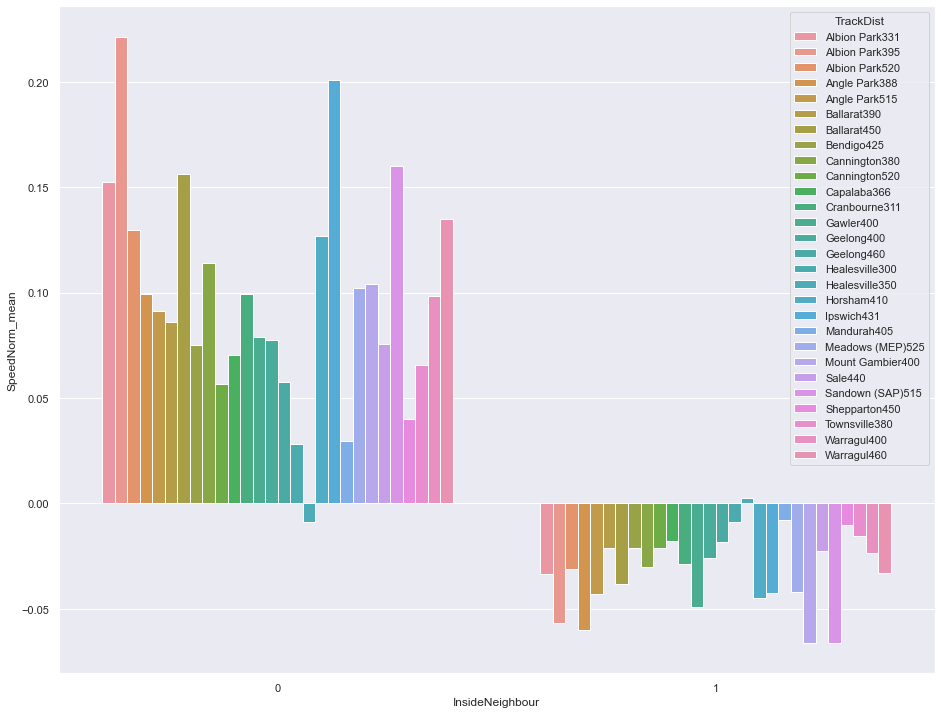

In [66]:
# Copy dataframe
df_temp = df.copy()

# Groupby TrackDist, aggregate average SpeedNorm and sample size
df_temp = df_temp.groupby(["TrackDist", "InsideNeighbour"], as_index=False).agg(SpeedNorm_mean=('SpeedNorm', 'mean'),
                                                                                SampleSize=('SpeedNorm', 'count'))

# Take only TrackDist with a large enough sample size (>=2500)
df_temp["MinSampleSize"] = df_temp.groupby("TrackDist")["SampleSize"].transform(lambda x: min(x))
df_temp = df_temp[df_temp["MinSampleSize"] >= 2500]

# Plot
sns.set_theme()
fig, ax = plt.subplots(figsize=(15.7, 12.27))
plt.rc('xtick',labelsize=15)
plt.rcParams["axes.labelsize"] = 15
plt.rc('ytick',labelsize=15)

sns.barplot(data=df_temp, x="InsideNeighbour", y="SpeedNorm_mean", hue="TrackDist")

Similarly for outside neighbours

<AxesSubplot:xlabel='OutsideNeighbour', ylabel='SpeedNorm_mean'>

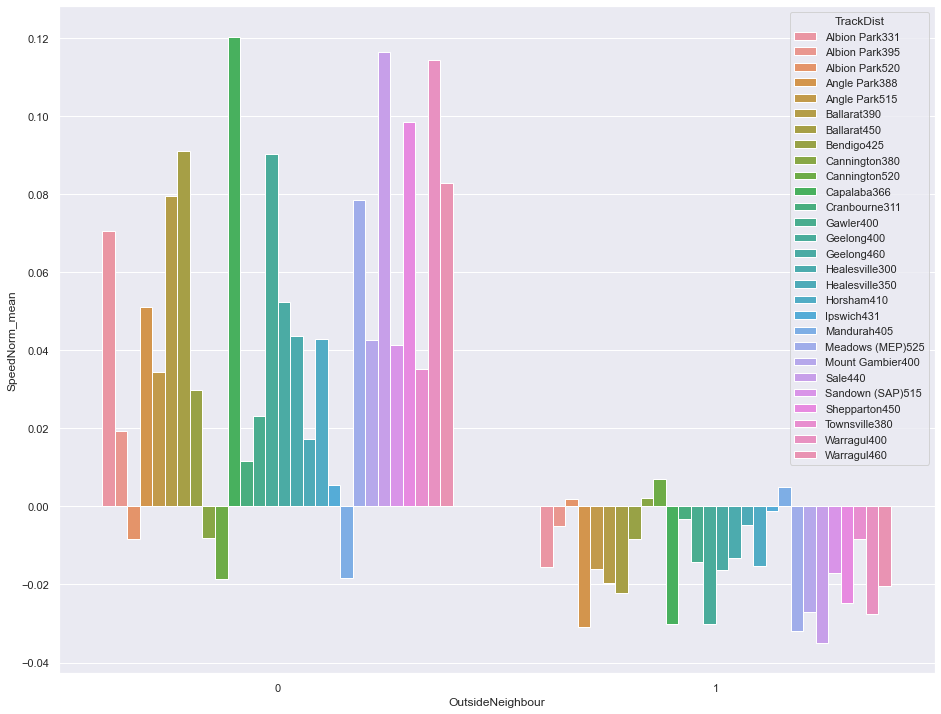

In [67]:
# Copy dataframe
df_temp = df.copy()

# Groupby TrackDist, aggregate average SpeedNorm and sample size
df_temp = df_temp.groupby(["TrackDist", "OutsideNeighbour"], as_index=False).agg(SpeedNorm_mean=('SpeedNorm', 'mean'),
                                                                                 SampleSize=('SpeedNorm', 'count'))

# Take only TrackDist with a large enough sample size (>=2500)
df_temp["MinSampleSize"] = df_temp.groupby("TrackDist")["SampleSize"].transform(lambda x: min(x))
df_temp = df_temp[df_temp["MinSampleSize"] >= 2500]

# Plot
sns.set_theme()
fig, ax = plt.subplots(figsize=(15.7, 12.27))
plt.rc('xtick',labelsize=15)
plt.rcParams["axes.labelsize"] = 15
plt.rc('ytick',labelsize=15)

sns.barplot(data=df_temp, x="OutsideNeighbour", y="SpeedNorm_mean", hue="TrackDist")